In [37]:
!pip install requests

In [98]:
%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
import requests
from sklearn.model_selection import train_test_split


import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

Note: you may need to restart the kernel to use updated packages.


# Import du data set  

In [39]:
df = pd.read_csv("/Users/mohameddjebali/Desktop/mspr/data/worldometer_data_raw.csv")

# Analyse du dataset

In [40]:
df.head()

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,Americas
1,Brazil,South America,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,Americas
2,India,Asia,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,South-EastAsia
3,Russia,Europe,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,Europe
4,South Africa,Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,Africa


Premièrement, on définit/décrit nos variables:

- *Country/Region* : Liste des pays affectés par la COVID-19

- *Total Cases* : Nombre cumulatif de cas confirmés à ce jour

- *New Cases* : Nombre de nouveaux cas confirmés chaque jour
(Contexte temporel manquant!)

- *Total Deaths* : Nombre cumulatif de décès à ce jour

- *New Deaths* : Nombre de nouveaux décès chaque jour
(Contexte temporel manquant!)

- *Total Recovered* : Nombre cumulatif de cas rétablis à ce jour

- *Active Cases* : Nombre cumulatif de cas actifs à ce jour
(Remarque : la définition d’origine indiquait « cas récupérés », mais il s’agit vraisemblablement d’une erreur. Il est attendu que cette variable représente les cas encore actifs.)

- *Serious, Critical* : Nombre cumulatif de cas graves/critique à ce jour

- *TotalCases/1M pop* : Nombre cumulatif de cas confirmés à ce jour pour un million d’habitants

- *Deaths/1M pop* : Nombre cumulatif de décès à ce jour pour un million d’habitants

- *Total Tests* : Nombre cumulatif de tests effectués à ce jour
(Contexte temporel manquant!)
- *Tests/1M pop* : Nombre cumulatif de tests effectués à ce jour pour un million d’habitants
(Contexte temporel manquant!)

- *WHO Population*: L'Organisation mondiale de la santé divise le monde en six régions.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         208 non-null    object 
 2   Population        208 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          4 non-null      float64
 5   TotalDeaths       188 non-null    float64
 6   NewDeaths         3 non-null      float64
 7   TotalRecovered    205 non-null    float64
 8   NewRecovered      3 non-null      float64
 9   ActiveCases       205 non-null    float64
 10  Serious,Critical  122 non-null    float64
 11  Tot Cases/1M pop  208 non-null    float64
 12  Deaths/1M pop     187 non-null    float64
 13  TotalTests        191 non-null    float64
 14  Tests/1M pop      191 non-null    float64
 15  WHO Region        184 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u



La méthode **df.info()** nous permet d'avoir une vue d'ensemble sur la structure du dataset : 

**structure du dataset** : 

- "shape" : 209 entrées (lignes) et 16 variables(colonnnes).
- Le typage des données et le nombre de variables par type de données  : on a des float64, int64 et object 
- Le nombre de valeurs non-nulles (donc les nulles) 

Ici on voit que toutes les variables comportent des valeurs nulles, à l'exception de "Country/Region" et "TotalCases" étant qu'ils ont 209 valeures non nulles 

On remarque également que certaines variables ont les mêmes nombre de valeurs manquantes. Ces variables/colonnes ne sont-elles pas des doublons?

L'objectif est de vérifier les données du dataset et de savoir si celles fournient dans le dataset est fiable 

### Etape 0 : Réagencement des colonnes 
D'abord nous allons réagencer l'ordre des colonnes pour une meilleures lisibilité. 
Elles ont été réorganisées en commençant par les variables catégorielles d'un coté et les numériques de l'autre pour une meilleure lisibilité des colonnes.


In [42]:
df.columns

Index(['Country/Region', 'Continent', 'Population', 'TotalCases', 'NewCases',
       'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered',
       'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop',
       'TotalTests', 'Tests/1M pop', 'WHO Region'],
      dtype='object')

In [43]:
df = df[['Continent', 'WHO Region','Country/Region', 'Population', 'TotalCases', 'NewCases','TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered','ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop','TotalTests', 'Tests/1M pop']]

<Axes: >

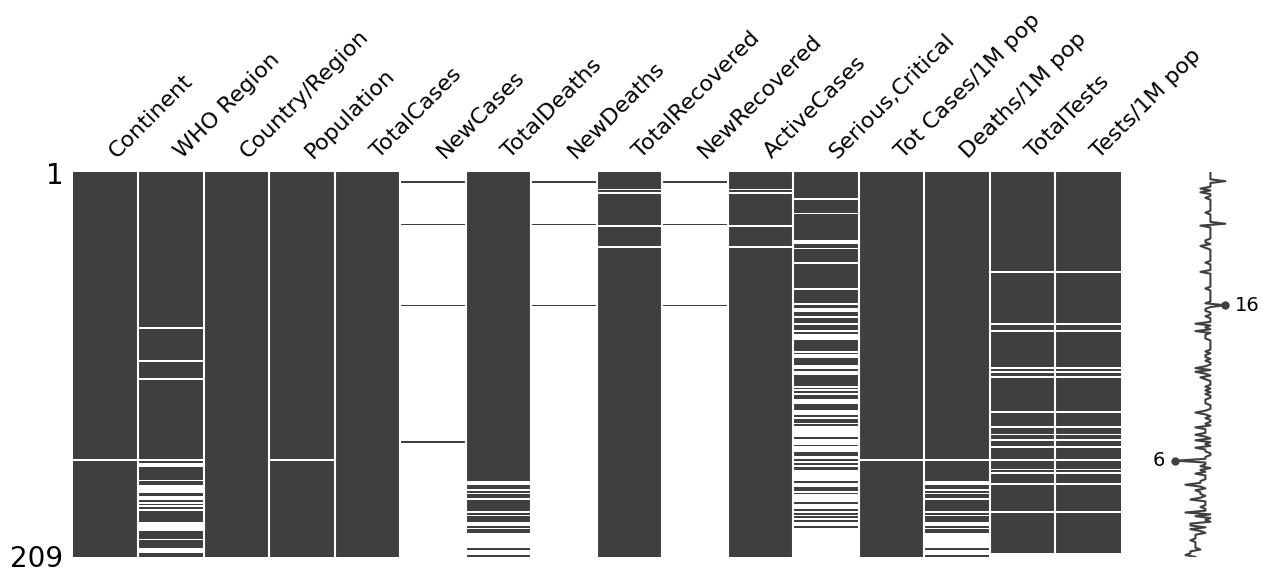

In [44]:
mno.matrix(df, figsize=(15,5))

## Etape 1 : Matplot 
### La heatmap 
La heatmap est une représentation visuelle permettant d'observer s'il y a des corrélations entre les colonnes du dataset

<Axes: >

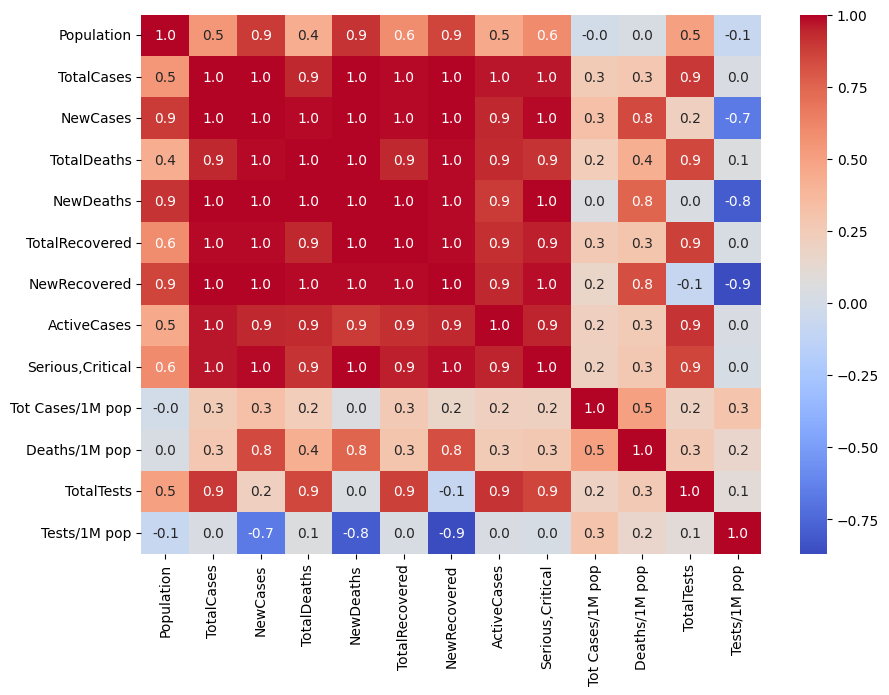

In [45]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".1f", cmap="coolwarm")

#### Résultat d'analyse de la heatmap
*Explication des couleurs de matrice* : 
- Les valeurs proches de *1.0* (en rouge foncé) indiquent une forte corrélation positive 
- Les valeurs proches de *-1.0* (en bleu foncé) indiquent une forte corrélation négative
- Les valeurs proches de *0* (en couleurs pâles) indiquent peu ou pas de corrélation

On peut voir une large zone rouge foncé dans le haut à gauche de la heatmap ce qui signifie qu'il y a un grand nombre de valeurs à forte coréélation. 

Om compte parmi elles, les colonnes (TotalCases, NewCases, TotalDeaths, NewDeaths, TotalRecovered, NewRecovered, ActiveCases, Serious,Critical).
Il est logique qu'on est une forte corrélation entre TotalCases et TotalDeaths 
TotalCases est fortement corrélé à (0.9) avec TotalCases et TotalDeaths ce qui est logique puisque les morts font partis des données de Total Cases et TotalDeaths.

### Boxplot

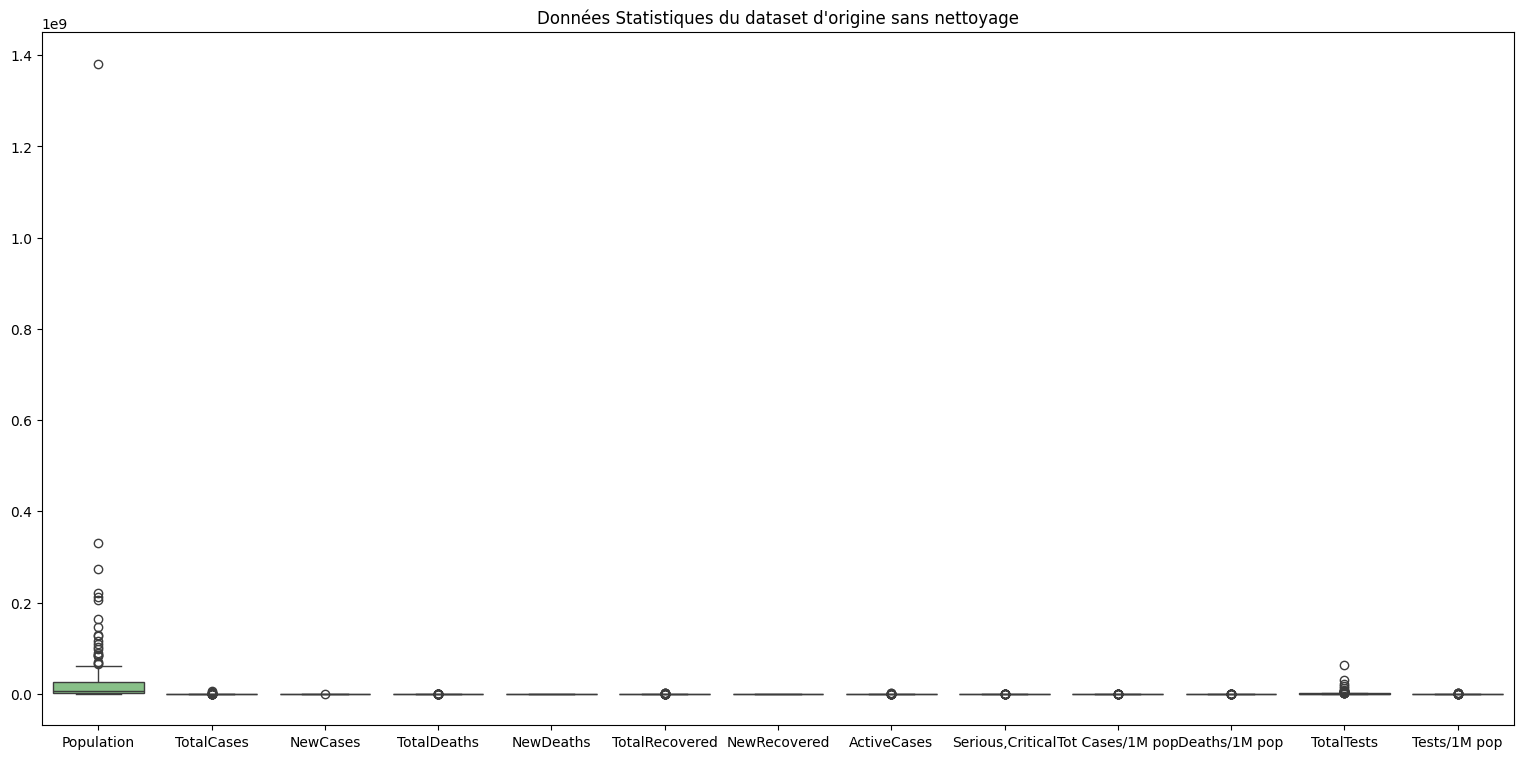

In [46]:
plt.figure(figsize=(19,9))
sns.boxplot(data=df,palette='Accent')
plt.title("Données Statistiques du dataset d'origine sans nettoyage")
plt.show()

Le *boxplot* qui représente l'intégralité du dataset ne peut pas être analysé correctement car il contient des valeurs extrèmes qui empâchent la lisibilité des autres données. Nous allons isolé chaque colonne dans un boxplot afin d'avoir une mise à l'écehelle adéquate avec les valeurs concernées. 

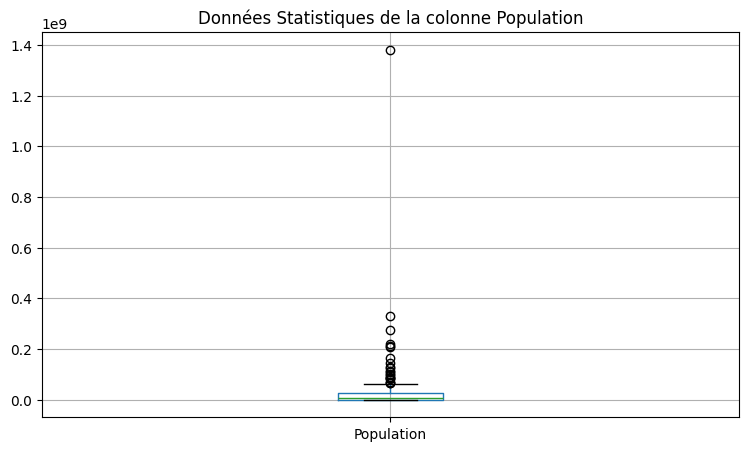

In [47]:
df.boxplot(column=['Population'],
figsize=(9,5))
plt.title("Données Statistiques de la colonne Population")
plt.show()

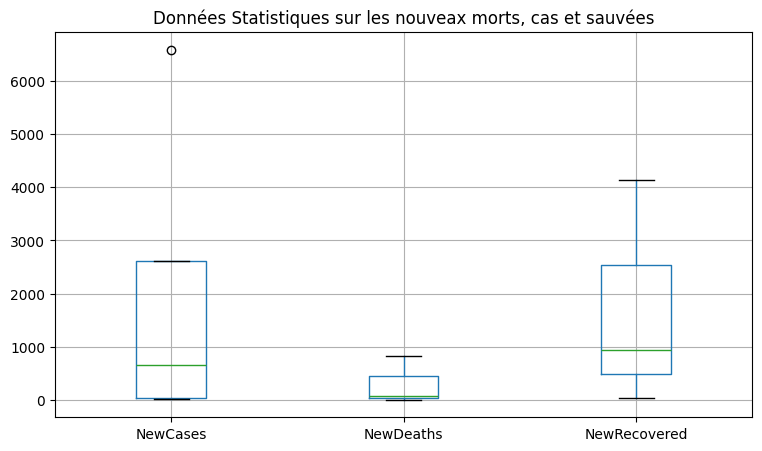

In [48]:
df.boxplot(column=['NewCases','NewDeaths','NewRecovered'], figsize=(9,5))
plt.title("Données Statistiques sur les nouveax morts, cas et sauvées")
plt.show()

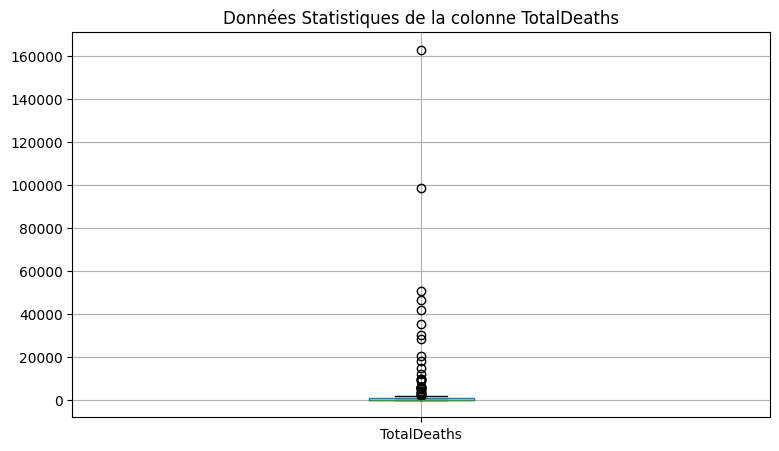

In [49]:
df.boxplot(column=['TotalDeaths'], figsize=(9,5))
plt.title("Données Statistiques de la colonne TotalDeaths")
plt.show()

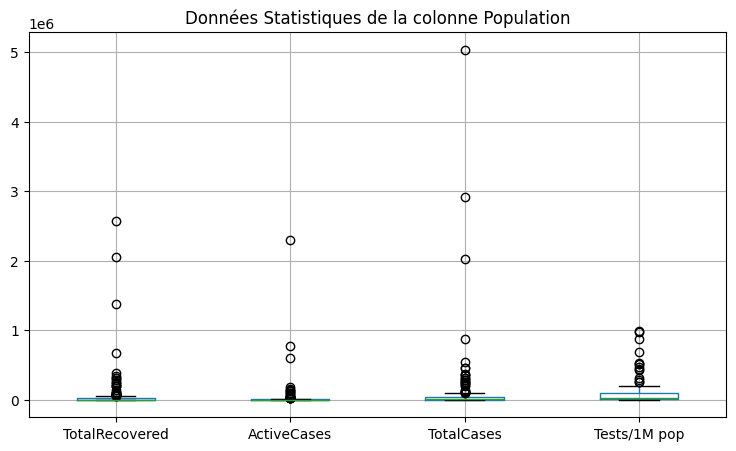

In [50]:
df.boxplot(['TotalRecovered', 'ActiveCases', 'TotalCases','Tests/1M pop'], figsize=(9,5))
plt.title("Données Statistiques de la colonne Population")
plt.show()

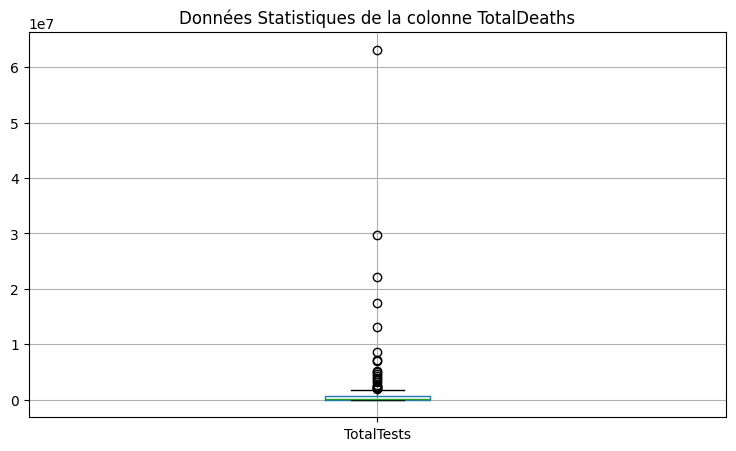

In [51]:
df.boxplot(column=['TotalTests'], figsize=(9,5))
plt.title("Données Statistiques de la colonne TotalDeaths")
plt.show()

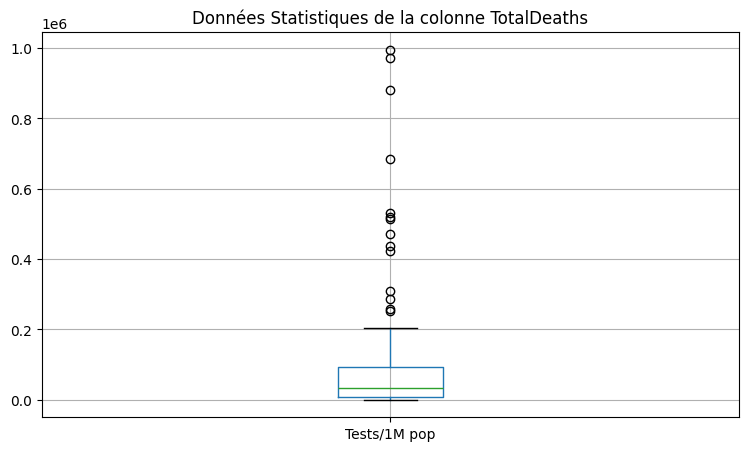

In [52]:
df.boxplot(column=['Tests/1M pop'], figsize=(9,5))
plt.title("Données Statistiques de la colonne TotalDeaths")
plt.show()

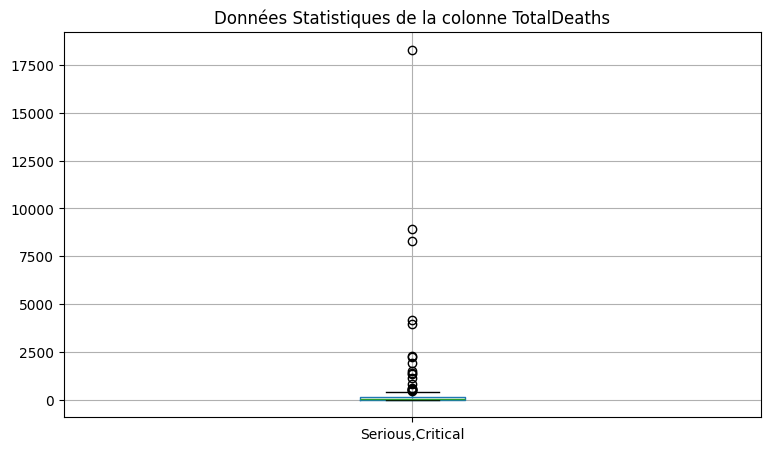

In [53]:
df.boxplot(column=['Serious,Critical'], figsize=(9,5))
plt.title("Données Statistiques de la colonne TotalDeaths")
plt.show()

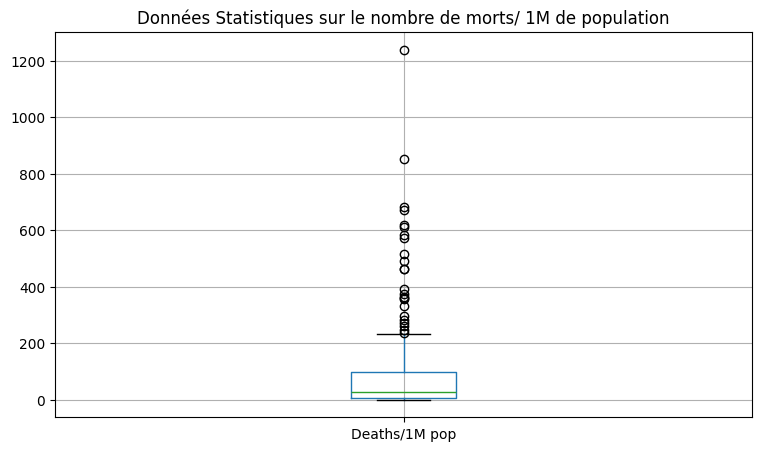

In [54]:
df.boxplot(column=['Deaths/1M pop'], figsize=(9,5))
plt.title("Données Statistiques sur le nombre de morts/ 1M de population")
plt.show()

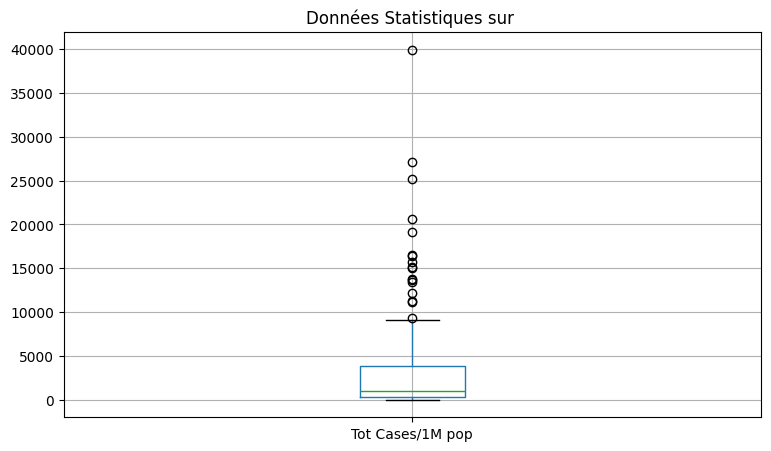

In [55]:
df.boxplot(column=['Tot Cases/1M pop'], figsize=(9,5))
plt.title("Données Statistiques sur ")
plt.show()

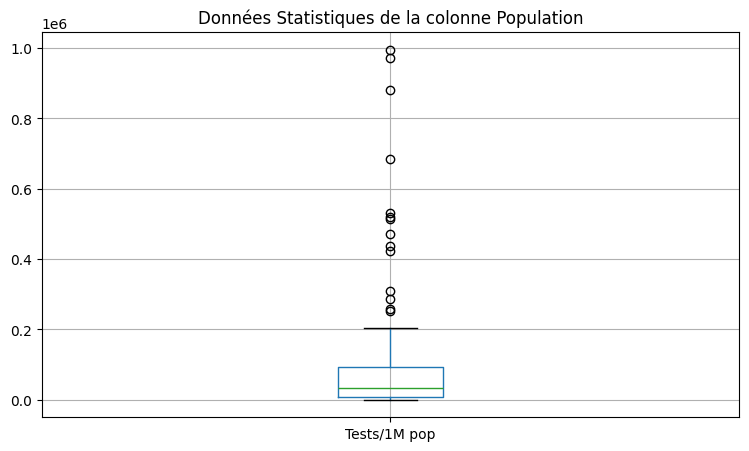

In [56]:
df.boxplot(column=['Tests/1M pop'], figsize=(9,5))
plt.title("Données Statistiques de la colonne Population")
plt.show()

In [57]:
df.describe()

,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop
count,2.080000e+02,2.090000e+02,4.000000,188.000000,3.000000,2.050000e+02,3.000000,2.050000e+02,122.000000,208.000000,187.000000,1.910000e+02,191.000000
mean,3.041549e+07,9.171850e+04,1980.500000,3792.590426,300.000000,5.887898e+04,1706.000000,2.766433e+04,534.393443,3196.024038,98.681176,1.402405e+06,83959.366492
std,1.047661e+08,4.325867e+05,3129.611424,15487.184877,451.199512,2.566984e+05,2154.779803,1.746327e+05,2047.518613,5191.986457,174.956862,5.553367e+06,152730.591240
min,8.010000e+02,1.000000e+01,20.000000,1.000000,1.000000,7.000000e+00,42.000000,0.000000e+00,1.000000,3.000000,0.080000,6.100000e+01,4.000000
25%,9.663140e+05,7.120000e+02,27.500000,22.000000,40.500000,3.340000e+02,489.000000,8.600000e+01,3.250000,282.000000,6.000000,2.575200e+04,8956.500000
50%,7.041972e+06,4.491000e+03,656.000000,113.000000,80.000000,2.178000e+03,936.000000,8.990000e+02,27.500000,1015.000000,29.000000,1.357020e+05,32585.000000
75%,2.575614e+07,3.689600e+04,2609.000000,786.000000,449.500000,2.055300e+04,2538.000000,7.124000e+03,160.250000,3841.750000,98.000000,7.576960e+05,92154.500000
max,1.381345e+09,5.032179e+06,6590.000000,162804.000000,819.000000,2.576668e+06,4140.000000,2.292707e+06,18296.000000,39922.000000,1238.000000,6.313960e+07,995282.000000


Maintenant, on fait une somme des valeurs manquantes:

In [58]:
df.isna().sum()

Continent             1
WHO Region           25
Country/Region        0
Population            1
TotalCases            0
NewCases            205
TotalDeaths          21
NewDeaths           206
TotalRecovered        4
NewRecovered        206
ActiveCases           4
Serious,Critical     87
Tot Cases/1M pop      1
Deaths/1M pop        22
TotalTests           18
Tests/1M pop         18
dtype: int64

<Axes: >

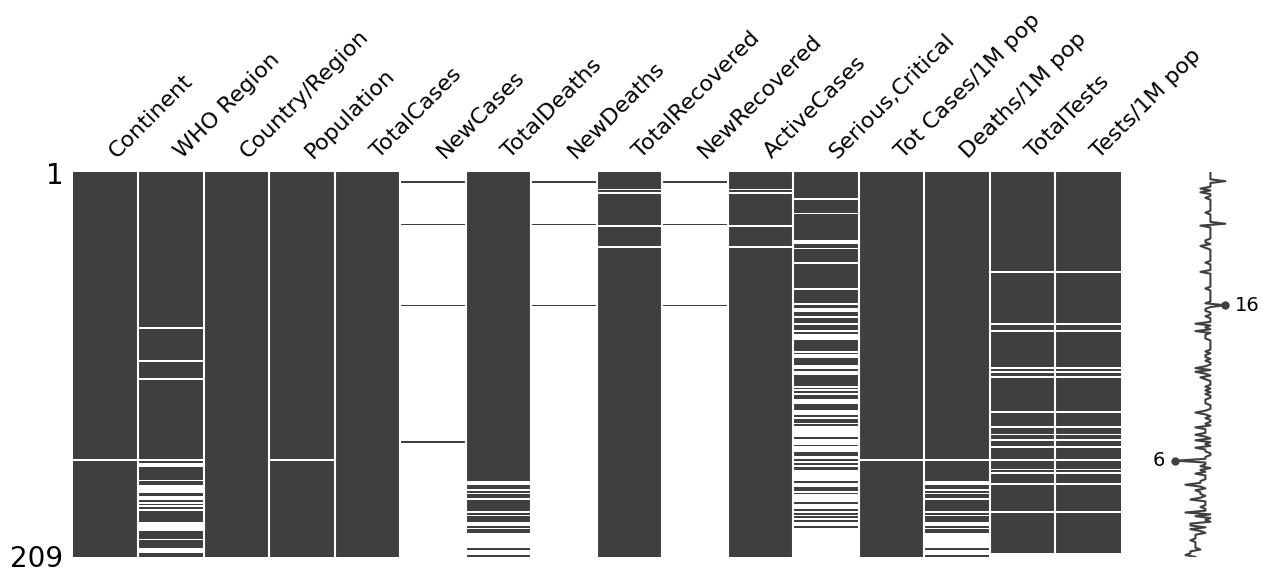

In [59]:
mno.matrix(df, figsize=(15,5))

In [60]:
df.isna().sum()

Continent             1
WHO Region           25
Country/Region        0
Population            1
TotalCases            0
NewCases            205
TotalDeaths          21
NewDeaths           206
TotalRecovered        4
NewRecovered        206
ActiveCases           4
Serious,Critical     87
Tot Cases/1M pop      1
Deaths/1M pop        22
TotalTests           18
Tests/1M pop         18
dtype: int64

## Analyse des valeures nulles par variables

<Axes: >

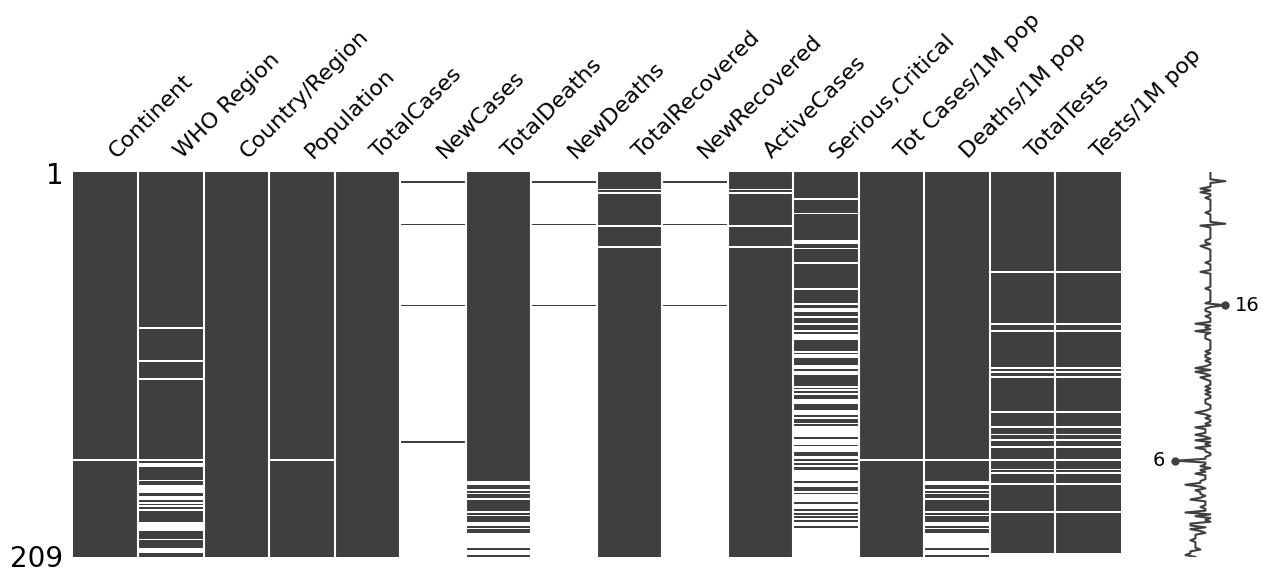

In [61]:
mno.matrix(df, figsize=(15,5))

On peut voir dans la colonne "Continent" et "Population qu'il y a une valeure "null". On peut supposer qu'un pays n'aurait pas été affilié à un continent puisque cette abscence de données est situé sur la même ligne du dataset comme on peut le voir la matrix ci-dessus. 

In [62]:
mask_population = df['Population'].isnull() | (df['Population'] == '')
mask_continent = df['Continent'].isnull() | (df['Continent'] == '')

ligne_suspecte = df[mask_population & mask_continent]

print("Ligne suspecte avec les colonnes Population et Continent vides:")
ligne_suspecte

Ligne suspecte avec les colonnes Population et Continent vides:


,Continent,WHO Region,Country/Region,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop
156,NaN,NaN,Diamond Princess,NaN,712,NaN,13.0,NaN,651.0,NaN,48.0,4.0,NaN,NaN,NaN,NaN


Après avoir mener des recherches . Le 'Diamond Princess' est un bateau et non un pays. On peut expliquer sa présence sur la dataset car le paquebot a été mis en quarantaine à cause de cas covid détecté à bord. C'est donc pas un pays donc on va le retirer du dataset.

# Nettoyage des données

In [63]:
df = df[df['Country/Region'] != 'Diamond Princess']

<Axes: >

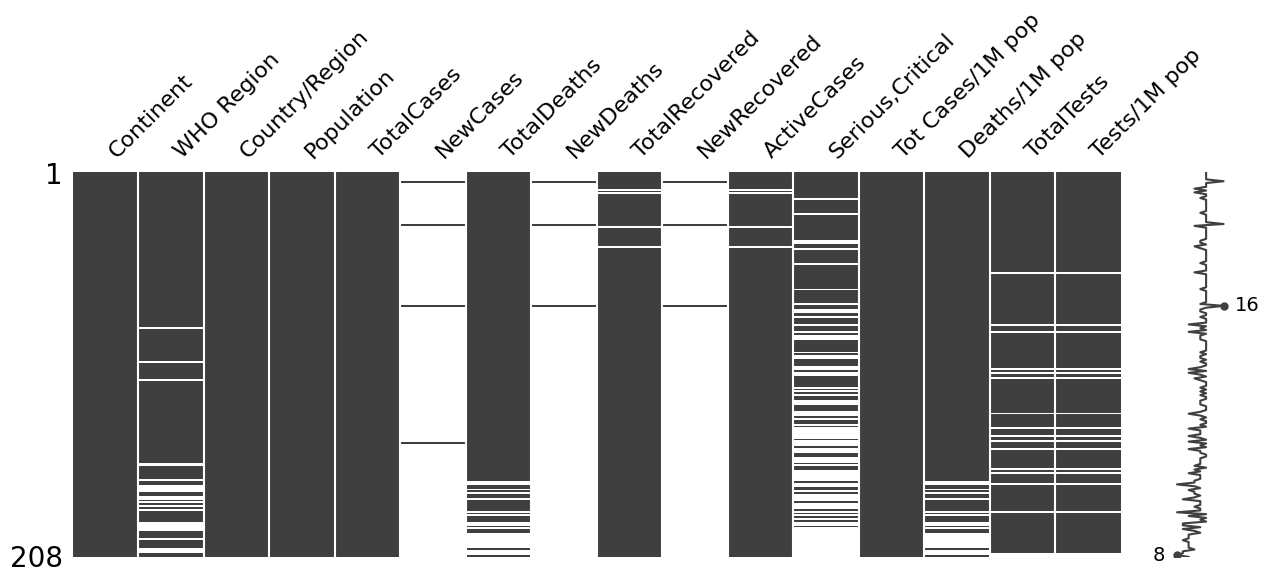

In [64]:
mno.matrix(df, figsize=(15,5))

On peut voir en se référant à la matrice que les colonnes "Continent" et "Population" ne présentent plus de valeurs manquantes visuellement, confirmant que les données nulles ont été correctement traitées.

In [65]:
df.isna().sum()

Continent             0
WHO Region           24
Country/Region        0
Population            0
TotalCases            0
NewCases            204
TotalDeaths          21
NewDeaths           205
TotalRecovered        4
NewRecovered        205
ActiveCases           4
Serious,Critical     87
Tot Cases/1M pop      0
Deaths/1M pop        21
TotalTests           17
Tests/1M pop         17
dtype: int64

On supprime les doublons en utilisant la méthode **drop_duplicates()**

In [66]:
df.drop_duplicates(inplace = True)

In [67]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
204    False
205    False
206    False
207    False
208    False
Length: 208, dtype: bool

On constate qu'il n'y a pas de doublons dans le dataset comme le nombre de lignes est identique à celui avant d'appliquer la méthode.

In [68]:
# Créer une colonne 
df['NewTotalCases'] = df['TotalDeaths'] + df['TotalRecovered'] + df['ActiveCases']
df

,Continent,WHO Region,Country/Region,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,NewTotalCases
0,North America,Americas,USA,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,5032179.0
1,South America,Americas,Brazil,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,2917562.0
2,Asia,South-EastAsia,India,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,2025409.0
3,Europe,Europe,Russia,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,871894.0
4,Africa,Africa,South Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,538184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,North America,NaN,Montserrat,4.992000e+03,13,NaN,1.0,NaN,10.0,NaN,2.0,NaN,2604.0,200.0,61.0,12220.0,13.0
205,North America,NaN,Caribbean Netherlands,2.624700e+04,13,NaN,NaN,NaN,7.0,NaN,6.0,NaN,495.0,NaN,424.0,16154.0,NaN
206,South America,NaN,Falkland Islands,3.489000e+03,13,NaN,NaN,NaN,13.0,NaN,0.0,NaN,3726.0,NaN,1816.0,520493.0,NaN
207,Europe,Europe,Vatican City,8.010000e+02,12,NaN,NaN,NaN,12.0,NaN,0.0,NaN,14981.0,NaN,NaN,NaN,NaN


<Axes: >

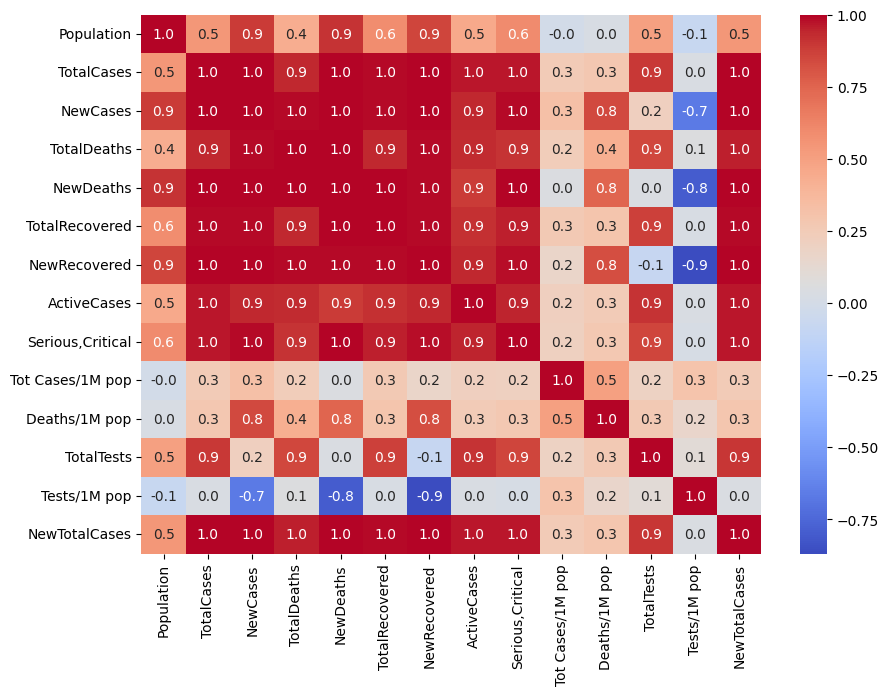

In [69]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".1f", cmap="coolwarm")

Cette figure permet de mieux représenter les valeurs nulles du dataset.

Mais aussi de se rendre compte de certaines aberrations.

Ici, on a des colonnes qui sont les copies conformes, on peut supposer que ce sont des "variables doublons":

- TotalCases et Tot Cases/1M pop ??
- TotalDeaths et Deaths/1M pop ?
- NewDeaths et NewRecovered ?
- TotalRecovered et ActiveCases ?
- TotalTests et Tests/1m pop ?



Nous allons donc supprimer ces dernières étant donnée qu'elles ont un niveau de corrélation à 1

In [70]:
df = df.drop(columns=["Tot Cases/1M pop", "Deaths/1M pop", "NewRecovered", "NewCases","Tests/1M pop","NewDeaths"], errors='ignore')

In [71]:
df.head()

,Continent,WHO Region,Country/Region,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
0,North America,Americas,USA,3.311981e+08,5032179,162804.0,2576668.0,2292707.0,18296.0,63139605.0,5032179.0
1,South America,Americas,Brazil,2.127107e+08,2917562,98644.0,2047660.0,771258.0,8318.0,13206188.0,2917562.0
2,Asia,South-EastAsia,India,1.381345e+09,2025409,41638.0,1377384.0,606387.0,8944.0,22149351.0,2025409.0
3,Europe,Europe,Russia,1.459409e+08,871894,14606.0,676357.0,180931.0,2300.0,29716907.0,871894.0
4,Africa,Africa,South Africa,5.938157e+07,538184,9604.0,387316.0,141264.0,539.0,3149807.0,538184.0


Ces deux points sont importants pour la préparation des données :

- **Suppression des variable**s dérivées : Les métriques normalisées "Tot Cases/1M pop", "Deaths/1M pop" et "Tests/1M pop" sont calculables à partir des données brutes existantes (TotalCases/Population, TotalDeaths/Population, etc.). Si on les conservait cela créerait une redondance qui pourrait biaiser les analyses.
 
- **Suppression des colonnes** avec trop de valeurs manquantes : "NewRecovered", "NewDeaths" et "NewCases" présentent plus de 200 valeurs manquantes, ce qui représente une proportion significative du dataset. Au lieu, d'imputer ces nombreuses valeurs manquantes, la suppression de ces colonnes est une approche raisonnable pour maintenir la qualité des données.

<Axes: >

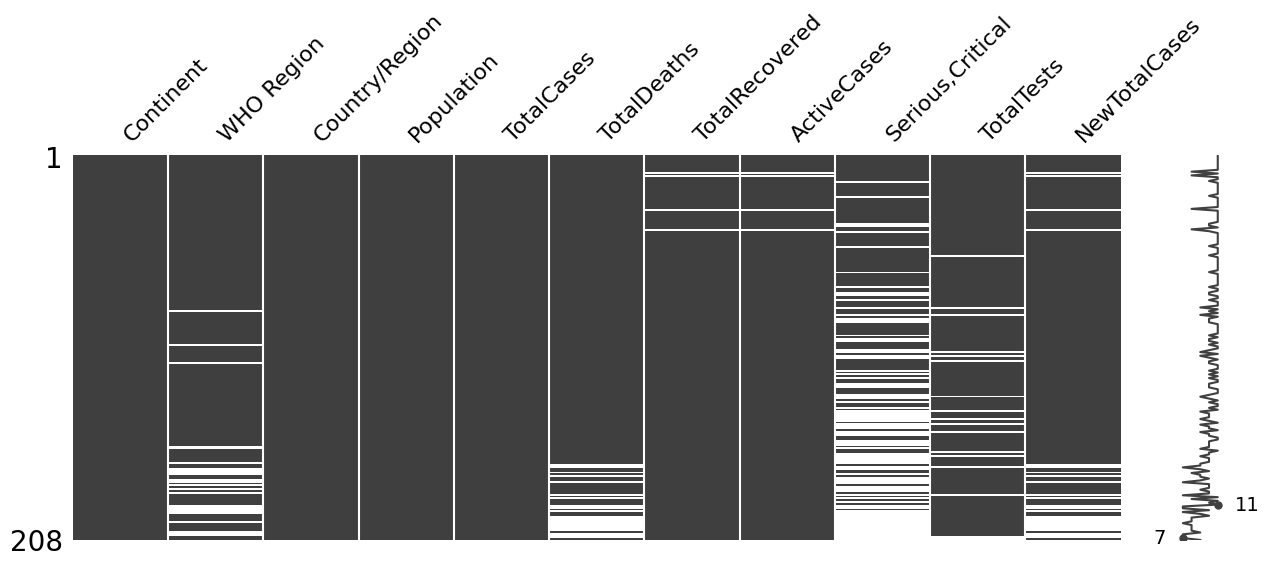

In [72]:
mno.matrix(df, figsize=(15,5))

<Axes: >

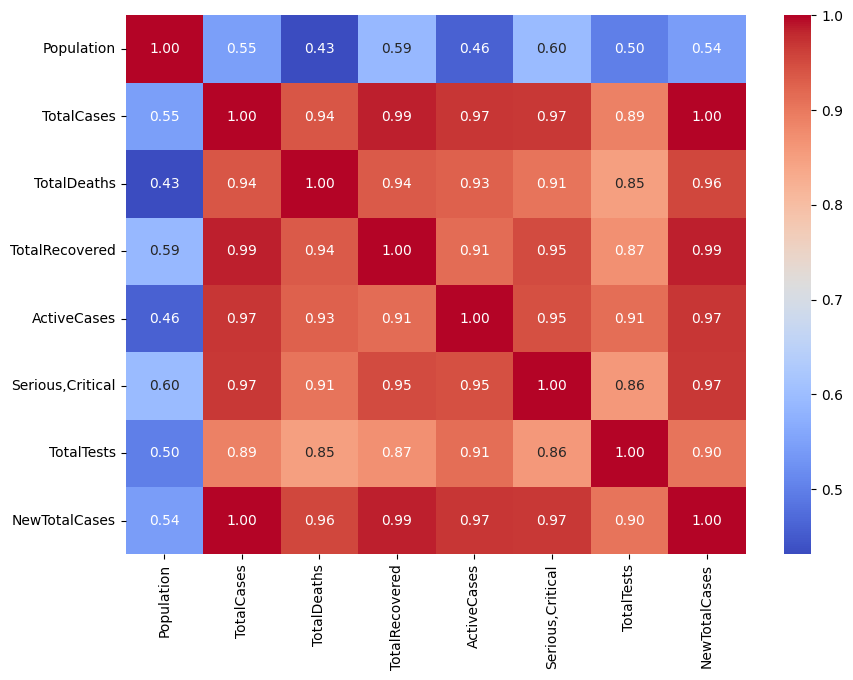

In [73]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".2f", cmap="coolwarm")

La corrélation est forte entre les colonnes TotalCases et TotalDeaths car les données de TotalDeaths sont contenus dans TotalCases.
On peut faire le même constat pour les variables TotalRecovered et TotalTests. 

<Axes: >

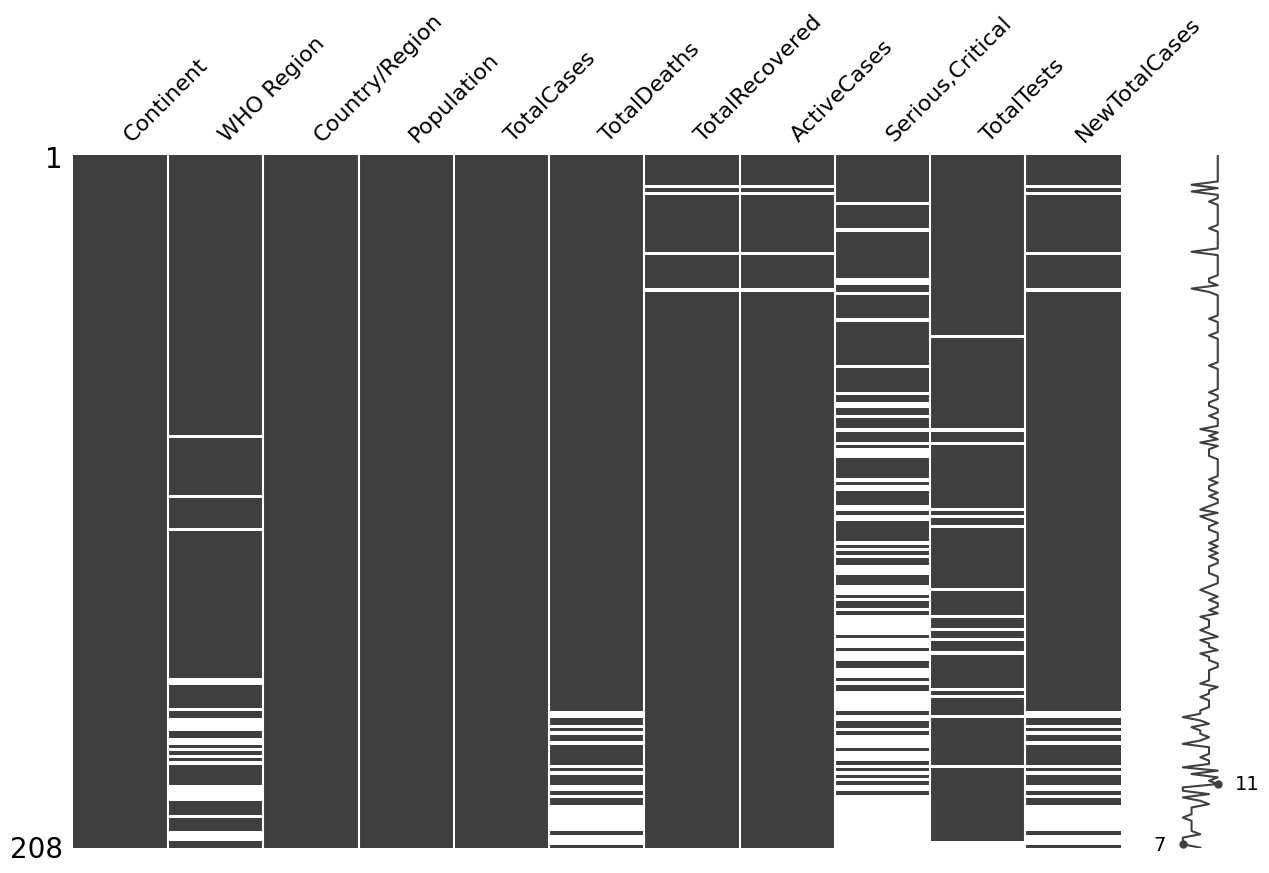

In [74]:
mno.matrix(df, figsize=(15,9))

On remplaceme les **NaN** par "**Non classé"** pour la colonne WHO Region.

In [75]:
df['WHO Region'] = df['WHO Region'].fillna("Non classé")

In [103]:
#Afficher les données du data set en aleatoire 
df.sample(20)

,continent,who_region,country,population,TotalCases,total_deaths,total_recovered,active_cases,serious_critical,total_tests,new_total_cases
57,Asia,Europe,Uzbekistan,33516027,28315,175,19291,8849,228,1377915,28315
173,North America,Non classé,Aruba,106812,263,3,114,146,5,14047,263
17,South America,Americas,Argentina,45236884,228195,4251,99852,124092,1150,794544,228195
155,Africa,Africa,Lesotho,2143943,742,23,175,544,8,8771,742
148,Europe,Europe,Andorra,77278,944,52,828,64,1,3750,944
90,Africa,Africa,Zambia,18430129,7164,199,5786,1179,8,90307,7164
97,Africa,EasternMediterranean,Djibouti,989387,5330,59,5057,214,8,59909,5330
62,South America,Americas,Venezuela,28427499,22299,195,12146,9958,42,1567431,22299
85,Africa,Africa,Gabon,2230563,7787,51,5609,2127,11,85369,7787
27,South America,Americas,Ecuador,17668824,90537,5877,71318,13342,378,258582,90537


On s'interroge sur comment on va remplacer les valeurs numériques manquantes par zéro, par la médiane, la moyenne. 
Quelle est la meilleure option pour avoir des données cohérentes ?

On procède au remplacement des valeurs nulles par des formules logiques.

**Pourquoi transformer TotalCases, TotalDeaths et TotalRecovered ?** <br>

Ces transformations aident à réduire la variance excessive dans les données. Sans cela, la variance serait dominée par quelques grands pays avec des chiffres très élevés, ce qui masquerait les différences entre la majorité des pays. 

En réduisant la variance, nous obtenons une distribution plus équilibrée où tous les pays peuvent être comparés de manière plus équitable.

### Imputation des valeurs manquantes de la colonne "ActiveCases":

In [76]:
# Afficher les lignes où ActiveCases est null
null_active_cases = df[df['ActiveCases'].isnull()]
null_active_cases

,Continent,WHO Region,Country/Region,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
9,Europe,Europe,Spain,46756648.0,354530,28500.0,NaN,NaN,617.0,7064329.0,NaN
11,Europe,Europe,UK,67922029.0,308134,46413.0,NaN,NaN,73.0,17515234.0,NaN
29,Europe,Europe,Sweden,10105596.0,81967,5766.0,NaN,NaN,38.0,863315.0,NaN
40,Europe,Europe,Netherlands,17138756.0,56982,6153.0,NaN,NaN,37.0,1079860.0,NaN


In [5221]:
# Filtrer le DataFrame pour ne conserver que les pays d'Europe
europe_df = df[df['Continent'] == 'Europe']

# Calculer la médiane de ActiveCases pour l'Europe
europe_active_cases_median = europe_df['ActiveCases'].median()

# Remplacer les valeurs NaN dans le DataFrame original
df['ActiveCases'] = df['ActiveCases'].fillna(europe_active_cases_median)

# Vérifier le nombre de valeurs NaN après remplacement
nan_count_after = df['ActiveCases'].isnull().sum()

# Créer un nouveau DataFrame avec seulement les lignes spécifiées
selected_rows = df.iloc[[9, 11, 29, 40]]
selected_rows

,Continent,WHO Region,Country/Region,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
9,Europe,Europe,Spain,46756648.0,354530,28500.0,NaN,1222.0,617.0,7064329.0,NaN
11,Europe,Europe,UK,67922029.0,308134,46413.0,NaN,1222.0,73.0,17515234.0,NaN
29,Europe,Europe,Sweden,10105596.0,81967,5766.0,NaN,1222.0,38.0,863315.0,NaN
40,Europe,Europe,Netherlands,17138756.0,56982,6153.0,NaN,1222.0,37.0,1079860.0,NaN


### Imputation des valeurs manquantes de la colonne "TotalDeaths":

In [5222]:
#Remplace les données manquantes de la colonne "TotalDeaths" par le résultat de la formule : "TotalCases" - "TotalRecovered" + "ActiveCases"

def fill_missing_total_deaths(row):
    if pd.isnull(row['TotalDeaths']):
        return int(round(row['TotalCases'] - (row['TotalRecovered'] + row['ActiveCases'] )))
    return row['TotalDeaths']

missing_total_deaths_before = df['TotalDeaths'].isnull().sum()

df['TotalDeaths'] = df.apply(fill_missing_total_deaths, axis=1)

missing_total_deaths_after = df['TotalDeaths'].isnull().sum()

print(f"Number of missing 'TotalDeaths' values before filling: {missing_total_deaths_before}")
print(f"Number of missing 'TotalDeaths' values after filling: {missing_total_deaths_after}")

Number of missing 'TotalDeaths' values before filling: 21
Number of missing 'TotalDeaths' values after filling: 0


### Imputation des valeurs manquantes de la colonne "TotalRecovered":

In [81]:
#Remplacer les données manquantes de la colonne "TotalRecovered" par le résultat de la formule : "TotalCases" - "TotalDeaths" + "ActiveCases"

def fill_missing_total_recovered(row):
    if pd.isnull(row['TotalRecovered']):
        return int(round(row['TotalCases'] - (row['TotalDeaths'] + row['ActiveCases'])))
    return row['TotalRecovered']

missing_total_deaths_before = df['TotalRecovered'].isnull().sum()

df['TotalRecovered'] = df.apply(fill_missing_total_recovered, axis=1)

missing_total_deaths_after = df['TotalRecovered'].isnull().sum()

selected_rows = df.iloc[[9, 11, 29, 40]]
selected_rows


,Continent,WHO Region,Country/Region,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
9,Europe,Europe,Spain,46756648.0,354530,28500.0,326030.0,NaN,617.0,7064329.0,NaN
11,Europe,Europe,UK,67922029.0,308134,46413.0,261721.0,NaN,73.0,17515234.0,NaN
29,Europe,Europe,Sweden,10105596.0,81967,5766.0,76201.0,NaN,38.0,863315.0,NaN
40,Europe,Europe,Netherlands,17138756.0,56982,6153.0,50829.0,NaN,37.0,1079860.0,NaN


In [82]:
# Créer une colonne calculée
df['NewTotalCases'] = df['TotalDeaths'] + df['TotalRecovered'] + df['ActiveCases']
df

,Continent,WHO Region,Country/Region,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
0,North America,Americas,USA,3.311981e+08,5032179,162804.0,2576668.0,2292707.0,18296.0,63139605.0,5032179.0
1,South America,Americas,Brazil,2.127107e+08,2917562,98644.0,2047660.0,771258.0,8318.0,13206188.0,2917562.0
2,Asia,South-EastAsia,India,1.381345e+09,2025409,41638.0,1377384.0,606387.0,8944.0,22149351.0,2025409.0
3,Europe,Europe,Russia,1.459409e+08,871894,14606.0,676357.0,180931.0,2300.0,29716907.0,871894.0
4,Africa,Africa,South Africa,5.938157e+07,538184,9604.0,387316.0,141264.0,539.0,3149807.0,538184.0
...,...,...,...,...,...,...,...,...,...,...,...
204,North America,Non classé,Montserrat,4.992000e+03,13,1.0,10.0,2.0,NaN,61.0,13.0
205,North America,Non classé,Caribbean Netherlands,2.624700e+04,13,NaN,7.0,6.0,NaN,424.0,NaN
206,South America,Non classé,Falkland Islands,3.489000e+03,13,NaN,13.0,0.0,NaN,1816.0,NaN
207,Europe,Europe,Vatican City,8.010000e+02,12,NaN,12.0,0.0,NaN,NaN,NaN


<Axes: >

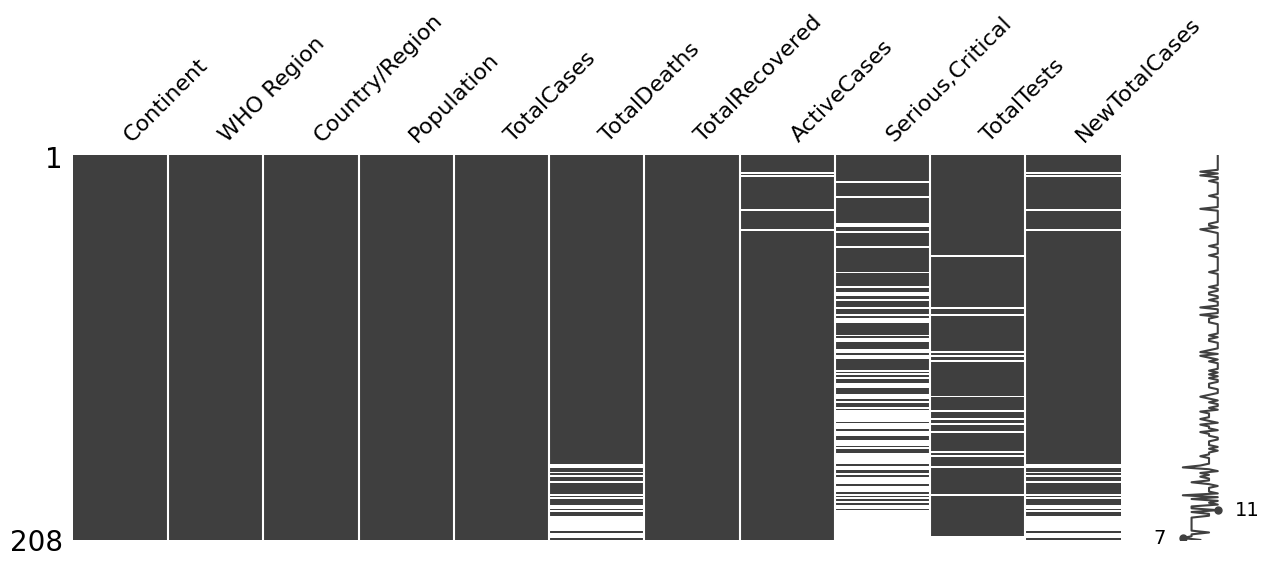

In [83]:
mno.matrix(df, figsize=(15,5))

In [84]:
# Comparer si deux colonnes sont identiques
if df['NewTotalCases'].equals(df['TotalCases']):
    print("Les colonnes sont identiques")
else:
    print("Les colonnes sont différentes")
    
    # Afficher le nombre de différences
    differences_count = (df['NewTotalCases'] != df['TotalCases']).sum()
    print(f"Nombre de différences trouvées : {differences_count}")
    
    # Afficher les premières lignes où il y a des différences
    print("\nExemples de différences :")
    diff_rows = df[df['NewTotalCases'] != df['TotalCases']][['NewTotalCases', 'TotalCases']]
    print(diff_rows.head())

Les colonnes sont différentes
Nombre de différences trouvées : 25

Exemples de différences :
     NewTotalCases  TotalCases
9              NaN      354530
11             NaN      308134
29             NaN       81967
40             NaN       56982
168            NaN         293


In [5227]:
df = df.drop(columns=['TotalCases'])
df

,Continent,WHO Region,Country/Region,Population,TotalDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotalTests,NewTotalCases
0,North America,Americas,USA,3.311981e+08,162804.0,2576668.0,2292707.0,18296.0,63139605.0,5032179.0
1,South America,Americas,Brazil,2.127107e+08,98644.0,2047660.0,771258.0,8318.0,13206188.0,2917562.0
2,Asia,South-EastAsia,India,1.381345e+09,41638.0,1377384.0,606387.0,8944.0,22149351.0,2025409.0
3,Europe,Europe,Russia,1.459409e+08,14606.0,676357.0,180931.0,2300.0,29716907.0,871894.0
4,Africa,Africa,South Africa,5.938157e+07,9604.0,387316.0,141264.0,539.0,3149807.0,538184.0
...,...,...,...,...,...,...,...,...,...,...
204,North America,Non classé,Montserrat,4.992000e+03,1.0,10.0,2.0,NaN,61.0,13.0
205,North America,Non classé,Caribbean Netherlands,2.624700e+04,0.0,7.0,6.0,NaN,424.0,13.0
206,South America,Non classé,Falkland Islands,3.489000e+03,0.0,13.0,0.0,NaN,1816.0,13.0
207,Europe,Europe,Vatican City,8.010000e+02,0.0,12.0,0.0,NaN,NaN,12.0


On peut voir sur la matrice que les colonnes "TotalRecovered" et "TotalDeaths" ne contiennent plus de valeurs nulles 

 ## Imputation des valeurs manquantes par la médiane

La méthode utilisée dans ce code remplace les valeurs manquantes de manière plus intelligente :

D'abord, le code regroupe les pays par continent
Ensuite, pour chaque continent, il calcule la valeur médiane (la valeur du milieu)
Enfin, il remplace les données manquantes par la médiane du continent correspondant

Par exemple, si un pays d'Afrique a une valeur manquante pour 'Serious,Critical', cette valeur sera remplacée par la médiane de tous les pays africains (et non par la médiane mondiale).
L'avantage est que les pays reçoivent des valeurs de remplacement qui correspondent mieux à leur région géographique, ce qui donne des résultats plus réalistes.

 ### Imputation des valeurs manquantes de la colonne "Serious, Critical":

In [85]:
# Pour la colonne 'Serious,Critical'
df['Serious,Critical'] = df.groupby('Continent')['Serious,Critical'] \
                             .transform(lambda x: x.fillna(x.median()))

# Pour la colonne 'TotalTests'
df['TotalTests'] = df.groupby('Continent')['TotalTests'] \
                     .transform(lambda x: x.fillna(x.median()))




**Pourquoi utiliser la médiane pour remplacer les valeurs manquantes?**

La **médiane** est plus pertinente que la moyenne dans notre cas car elle n'est pas influencée par les valeurs extrêmes qui augmentent artificiellement la variance. 

Par exemple, quelques pays comme la Chine ou les États-Unis avec des chiffres énormes augmenteraient considérablement la variance et fausseraient la moyenne.

La médiane représente mieux la situation "typique" de la majorité des pays, préservant ainsi une variance plus naturelle dans les données


Ces choix méthodologiques permettent d'obtenir des données avec une variance plus représentative pour réaliser une analyse pertinente.

<Axes: >

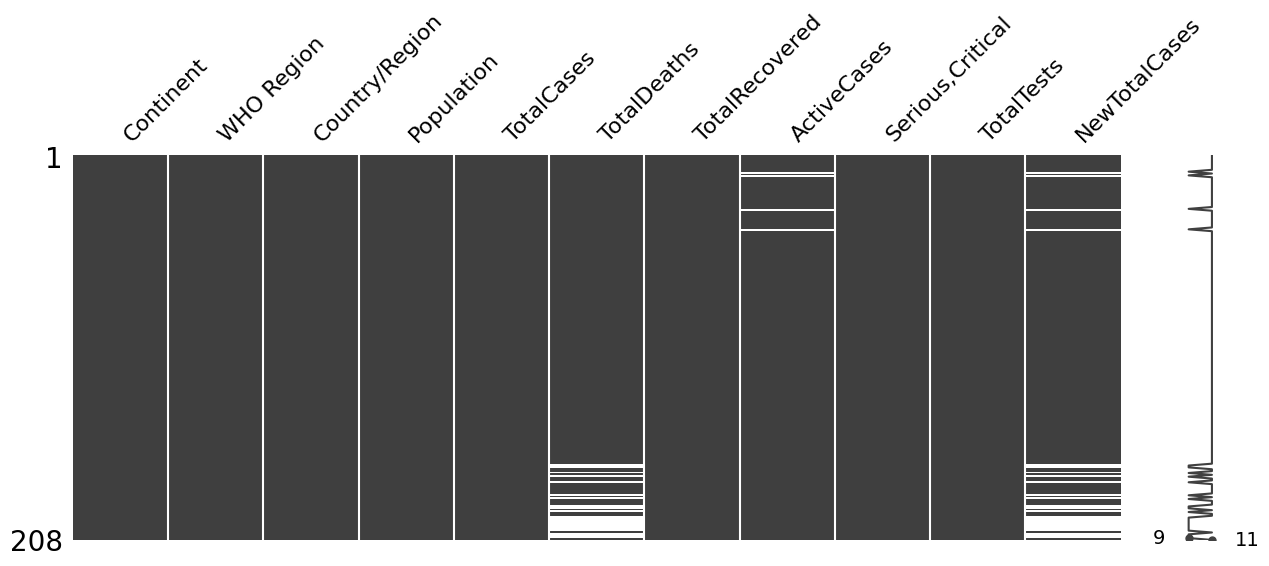

In [86]:
mno.matrix(df, figsize=(15,5))

On peut voir sur la matrice que la colonne **"Serious, Critical"** ne contient plus de valeurs nulles 

<Axes: >

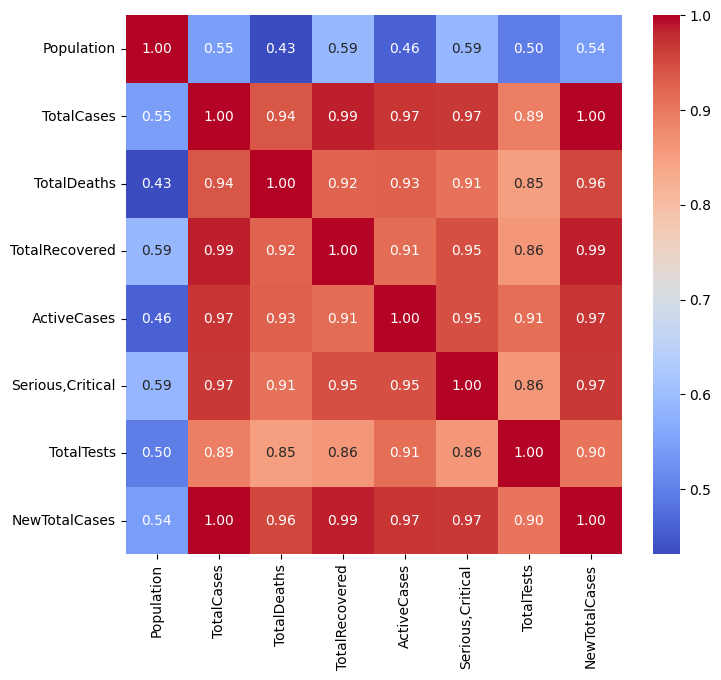

In [87]:
plt.figure(figsize=(8, 7))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [88]:
df.columns

Index(['Continent', 'WHO Region', 'Country/Region', 'Population', 'TotalCases',
       'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests', 'NewTotalCases'],
      dtype='object')

## Conversion des valeurs numérques en int

In [90]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].fillna(0).astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 0 to 208
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Continent         208 non-null    object
 1   WHO Region        208 non-null    object
 2   Country/Region    208 non-null    object
 3   Population        208 non-null    int64 
 4   TotalCases        208 non-null    int64 
 5   TotalDeaths       208 non-null    int64 
 6   TotalRecovered    208 non-null    int64 
 7   ActiveCases       208 non-null    int64 
 8   Serious,Critical  208 non-null    int64 
 9   TotalTests        208 non-null    int64 
 10  NewTotalCases     208 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 19.5+ KB


# Normalisation des colonnes

In [92]:
columns_mapping = {
    "Country/Region": "country",
    "WHO Region": "who_region",
    "NewTotalCases": "new_total_cases",
    "TotalDeaths": "total_deaths",
    "TotalRecovered": "total_recovered",
    "Serious,Critical": "serious_critical",
    "TotalTests": "total_tests",
    "Population": "population",
    "Continent": "continent",
    "ActiveCases":"active_cases"
}
df = df.rename(columns=columns_mapping)
df

,continent,who_region,country,population,TotalCases,total_deaths,total_recovered,active_cases,serious_critical,total_tests,new_total_cases
0,North America,Americas,USA,331198130,5032179,162804,2576668,2292707,18296,63139605,5032179
1,South America,Americas,Brazil,212710692,2917562,98644,2047660,771258,8318,13206188,2917562
2,Asia,South-EastAsia,India,1381344997,2025409,41638,1377384,606387,8944,22149351,2025409
3,Europe,Europe,Russia,145940924,871894,14606,676357,180931,2300,29716907,871894
4,Africa,Africa,South Africa,59381566,538184,9604,387316,141264,539,3149807,538184
...,...,...,...,...,...,...,...,...,...,...,...
204,North America,Non classé,Montserrat,4992,13,1,10,2,5,61,13
205,North America,Non classé,Caribbean Netherlands,26247,13,0,7,6,5,424,0
206,South America,Non classé,Falkland Islands,3489,13,0,13,0,71,1816,0
207,Europe,Europe,Vatican City,801,12,0,12,0,24,472841,0


# Dataset transformé

In [93]:
df = df.drop_duplicates()

In [94]:
# On affiche le df transformé
df.head()

,continent,who_region,country,population,TotalCases,total_deaths,total_recovered,active_cases,serious_critical,total_tests,new_total_cases
0,North America,Americas,USA,331198130,5032179,162804,2576668,2292707,18296,63139605,5032179
1,South America,Americas,Brazil,212710692,2917562,98644,2047660,771258,8318,13206188,2917562
2,Asia,South-EastAsia,India,1381344997,2025409,41638,1377384,606387,8944,22149351,2025409
3,Europe,Europe,Russia,145940924,871894,14606,676357,180931,2300,29716907,871894
4,Africa,Africa,South Africa,59381566,538184,9604,387316,141264,539,3149807,538184


<Axes: >

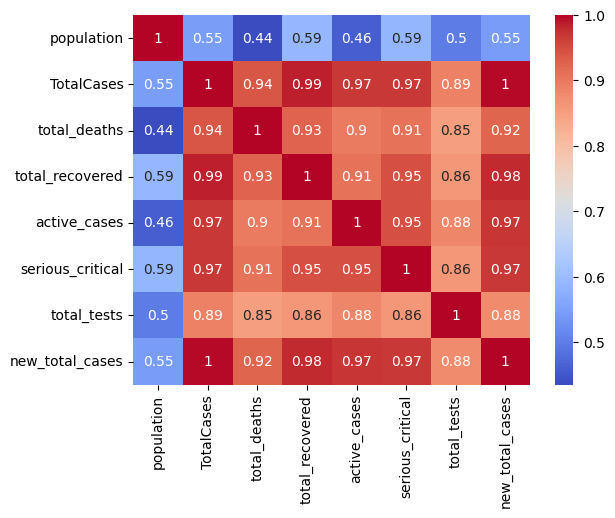

In [95]:
sns.heatmap(df.select_dtypes('number').corr(),annot=True, cmap="coolwarm")

# Préparation du jeu de données à entrainer 

In [99]:
# Pour un split sans variable cible spécifique avec une répartition 80% d'entrainement et 20% de test
X = df  
X_train, X_test = train_test_split(
    X, 
    test_size=0.2,
    random_state=42
)


Absence de varaibale cible :

In [5240]:
print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_test: {X_test.shape}")

Taille de X_train: (166, 10)
Taille de X_test: (42, 10)


# Chargement des données

## Connexion à PostgreSQL

In [ ]:
import psycopg2
import time

def checkpostgres(max_retries=5):
    print("🔍 Vérification de la connexion à PostgreSQL...", flush=True)
    
    for attempt in range(max_retries):
        print(f"🟡 Tentative {attempt + 1}/{max_retries}...", flush=True)
        
        try:
            conn = psycopg2.connect(
                dbname="covid_db",
                user="mohameddjebali",
                password="/Namouster5996/",
                host="localhost",
                port=5432
            )
            conn.close()
            print("✅ Connexion PostgreSQL réussie !", flush=True)
            return True
        except psycopg2.OperationalError as e:
            print(f"⚠️ PostgreSQL inaccessible : {e}", flush=True)
            time.sleep(5)

    print("❌ PostgreSQL inaccessible après plusieurs tentatives.", flush=True)
    return False

# Appel de la fonction pour test
if __name__ == "__main__":
    checkpostgres()


🔍 Vérification de la connexion à PostgreSQL...
🟡 Tentative 1/5...
✅ Connexion PostgreSQL réussie !


In [ ]:


# Se connecter à la base de données
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="covid_db",
    user="mohameddjebali",
    password="/Namouster5996/"
)

# Créer un curseur pour faire des requêtes SQL
cursor = conn.cursor()

# Créer les tables si elles n'existent pas déjà
cursor.execute("""
    CREATE TABLE IF NOT EXISTS worldometer (
    id SERIAL PRIMARY KEY, 
    continent VARCHAR(100) NOT NULL,
    who_region VARCHAR(100) NOT NULL,
    country VARCHAR(100) NOT NULL,
    population INT NOT NULL,
    total_tests INT NOT NULL,
    total_cases INT NOT NULL,
    total_deaths INT NOT NULL,
    total_recovered INT NOT NULL,
    serious_critical INT NOT NULL
    );
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS countries (
    id SERIAL PRIMARY KEY, 
    country VARCHAR(100) NOT NULL, 
    continent VARCHAR(100) NOT NULL,
    who_region VARCHAR(100) NOT NULL,
    population INT NOT NULL
    );
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS health_statistics (
    id SERIAL PRIMARY KEY, 
    country VARCHAR(100) NOT NULL,
    total_cases INT NOT NULL,
    total_deaths INT NOT NULL,
    total_recovered INT NOT NULL,
    serious_critical INT NOT NULL
    );
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS testing_statistics (
    id SERIAL PRIMARY KEY, 
    country VARCHAR(100) NOT NULL,
    total_tests INT NOT NULL
    );
""")

# Boucle pour insérer les données dans la base de données
for index, row in df.iterrows():
    try:
        # Extraire les valeurs depuis chaque ligne du DataFrame
        country = row['country']
        continent = row['continent']
        who_region = row['who_region']
        population = row['population']
        total_tests = row['total_tests']
        total_cases = row['new_total_cases']  # Note que 'NewTotalCases' a été mappé vers 'new_total_cases'
        total_deaths = row['total_deaths']
        total_recovered = row['total_recovered']
        serious_critical = row['serious_critical']
        active_cases = row['active_cases']
        
        # Créer les requêtes SQL pour insérer les données dans les différentes tables
        worldometer_sql = """
            INSERT INTO worldometer (continent, who_region, country, population, total_tests, total_cases, total_deaths, total_recovered, serious_critical)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """
        
        countries_sql = """
            INSERT INTO countries (country, continent, who_region, population)
            VALUES (%s, %s, %s, %s);
        """
        
        health_statistics_sql = """
            INSERT INTO health_statistics (country, total_cases, total_deaths, total_recovered, serious_critical)
            VALUES (%s, %s, %s, %s, %s);
        """
        
        testing_statistics_sql = """
            INSERT INTO testing_statistics (country, total_tests)
            VALUES (%s, %s);
        """
        
        # Exécuter les requêtes d'insertion avec les valeurs de la ligne
        cursor.execute(countries_sql, (country, continent, who_region, population))
        cursor.execute(health_statistics_sql, (country, total_cases, total_deaths, total_recovered, serious_critical))
        cursor.execute(testing_statistics_sql, (country, total_tests))
        cursor.execute(worldometer_sql, (continent, who_region, country, population, total_tests, total_cases, total_deaths, total_recovered, serious_critical))

        # Valider les changements dans la base de données
        conn.commit()
        print(f"✅ sucess")

    except psycopg2.Error as e:
        print(f"❌ Erreur lors de l'insertion des données pour {country}: {e}")

# Fermer le curseur et la connexion après avoir inséré toutes les données
cursor.close()
conn.close()

print("✅ Données chargées dans PostgreSQL")

✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅ sucess
✅

In [105]:
df.to_csv("/Users/mohameddjebali/Desktop/mspr/data/data-migration/worldometer_data_clean.csv", index=False, header=True)